In [2]:
#Access data displayed on the website through html
import pandas as pd
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp = pd.read_html(sp_url, header = 0)[0]
sp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   GICS Sector            503 non-null    object
 3   GICS Sub-Industry      503 non-null    object
 4   Headquarters Location  503 non-null    object
 5   Date added             503 non-null    object
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.6+ KB


In [25]:
#Access data from Yahoo Finance
import yfinance as yf
from datetime import datetime
start = '2019-12-01'
end = datetime(2022,5, 24)
df_MSFT = yf.download(tickers=['MSFT'], start = start, end = end)
df_MSFT.info()


#Obtain 1-minute data over last five days, auto_adjust means adjusting close prices for corporate actions
#minutes data only available for last few days
symbol = 'MSFT'
ticker = yf.Ticker(symbol)
data = ticker.history(period = '5d', interval = '1m', actions = True, auto_adjust = True)
data.info()

#Access option chains via yhfinance
ticker.options  #Get all maturities of listed options
options = ticker.option_chain('2024-09-13') #Get for specific maturity
options.calls.info()




[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 624 entries, 2019-12-02 to 2022-05-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       624 non-null    float64
 1   High       624 non-null    float64
 2   Low        624 non-null    float64
 3   Close      624 non-null    float64
 4   Adj Close  624 non-null    float64
 5   Volume     624 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 34.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1949 entries, 2024-08-30 09:30:00-04:00 to 2024-09-06 15:59:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1949 non-null   float64
 1   High          1949 non-null   float64
 2   Low           1949 non-null   float64
 3   Close         1949 non-null   float64
 4   Volume        1949 non-null   int64  
 5   Dividends     1949 non-null   float64
 6   Sto

In [27]:
#Get data from Zipline, require a custom environment, check zipline_data_demo.ipynb
#Similar for Quantopian platform.
#Also Quandl data

In [3]:
import requests
import pandas as pd
import time

header = {'User-Agent': 'ooooaugust@gmail.com'}

# Fetch the JSON file containing company tickers and CIK numbers from the SEC
tickers_cik = requests.get('https://www.sec.gov/files/company_tickers.json', headers=header)

# Normalize the JSON response and create a pandas DataFrame. Normalize works by flattening the structured json data into panada dataframe
tickers_cik = pd.json_normalize(pd.json_normalize(tickers_cik.json(), max_level=0).values[0])

# Convert the CIK numbers to strings and zero-pad them to 10 digits
tickers_cik['cik_str'] = tickers_cik['cik_str'].astype(str).str.zfill(10)


#Function to query the fundamental data from EDGAR with the cik specified, tag is the attribute we want to look at, default to b eeverything
def EDGAR_query(cik: str, header: dict, tag: list = None) -> pd.DataFrame:
    url = 'https://data.sec.gov/api/xbrl/companyfacts/CIK' + cik + '.json'
    response = requests.get(url, headers=header)

    if tag == None:
        tags = list(response.json()['facts']['us-gaap'].keys())  #This line can be used to check which tags are available. 
    else:
        tags = tag

    company_data = pd.DataFrame()

    for i in range(len(tags)):
        try:
            tag = tags[i]
            units = list(response.json()['facts']['us-gaap'][tag]['units'].keys())[0]
            data = pd.json_normalize(response.json()['facts']['us-gaap'][tag]['units'][units])
            data['tag'] = tag
            data['units'] = units
            company_data = pd.concat([company_data, data], ignore_index=True)
        except:
            print(tag + ' not found.')

    return company_data



In [4]:
#Concatenate all the data into panda dataframe
EDGAR_data = pd.DataFrame()

for i in range(10):
    cik = tickers_cik['cik_str'][i]
    ticker = tickers_cik['ticker'][i]
    title = tickers_cik['title'][i]

    company_data = EDGAR_query(cik=cik, header = header, tag=["RevenueFromContractWithCustomerExcludingAssessedTax"])
    company_data['cik'] = cik
    company_data['ticker'] = ticker
    company_data['title'] = title

    # Filter for quarterly data only
    try:
        company_data = company_data[company_data['frame'].str.contains('Q') == True]  # Keep only quarterly data
    except:
        print('frame not a column.')

    EDGAR_data = pd.concat([EDGAR_data, company_data], ignore_index=True)
    print(i)
    time.sleep(0.1)  # Be polite to the API

0
1
2
3
4
5
6
RevenueFromContractWithCustomerExcludingAssessedTax not found.
frame not a column.
7
RevenueFromContractWithCustomerExcludingAssessedTax not found.
frame not a column.
8
9


In [1]:
import requests
import os
from zipfile import ZipFile
from io import BytesIO
from pathlib import Path

SEC_URL = 'https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/'
first_year, this_year, this_quarter = 2014, 2018, 3
past_years = range(2014, this_year)
filing_periods = [(y, q) for y in past_years for q in range(1, 5)]
filing_periods.extend([(this_year, q) for q in range(1, this_quarter + 1)])

# Add headers to requests
headers = {'User-Agent': 'ooooaugust@gmail.com'}  # Replace with your email or domain

for i, (yr, qtr) in enumerate(filing_periods, 1):
    filing = f'{yr}q{qtr}_notes.zip'
    path = Path(os.getcwd()) /'US Fundamental Data'/ f'{yr}_{qtr}' / 'source'
    
    # Make request with headers
    response = requests.get(SEC_URL + filing, headers=headers)
    
    # Check the response status
    if response.status_code != 200:
        print(f"Failed to download {filing}: Status code {response.status_code}")
        continue

    print(f"Downloaded {filing} successfully. Status code: {response.status_code}")
    
    # Check the first few bytes of the response content
    print(response.content[:100])  # Print the first 100 bytes of the response to inspect it
    
    # Try unzipping the content only if it's a valid response
    try:
        with ZipFile(BytesIO(response.content)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                # Ensure the directory exists
                local_file.parent.mkdir(parents=True, exist_ok=True)
                
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except Exception as e:
        print(f"Error unzipping {filing}: {e}")

Downloaded 2014q1_notes.zip successfully. Status code: 200
b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x8as\x8bQ\xd4\x962\x1cd8\t\x00\x07\xb8!\x00\x07\x00\x1c\x00sub.tsvUT\t\x00\x03T\xc8\xd3_T\xc8\xd3_ux\x0b\x00\x01\x04(Y\x12\x00\x04\x01\x02\x10\x00\xec\\\xdbr\xdbF\xb6}\xee\xf3\x15x\x9b\xb8\xcaP\xd0\x8d\xbeAoM\x10"1\x02\x01\x1a\x04%\xcb5/\xb2,'
Downloaded 2014q2_notes.zip successfully. Status code: 200
b"PK\x03\x04\x14\x00\x00\x00\x08\x00 z\x8bQ\xc7\xab\xcf\xc3\xf1\xd1\n\x00^\x99'\x00\x07\x00\x1c\x00sub.tsvUT\t\x00\x03\xbc\xd3\xd3_\xbc\xd3\xd3_ux\x0b\x00\x01\x04(Y\x12\x00\x04\x01\x02\x10\x00\xe4[]s\xdb\xb8\x92}\xc6\xfe\nT\xdd\xaa\xdd\xa4*\xf4\x10\x00\xf1A\xbf\xdc\xa2$ZbL\x91\nI\xd9Q\xde"
Downloaded 2014q3_notes.zip successfully. Status code: 200
b'PK\x03\x04\x14\x00\x00\x00\x08\x00\xd6~\x8bQ,\x88\xae\xa6B\xd3\t\x000\xdc#\x00\x07\x00\x1c\x00sub.tsvUT\t\x00\x03\x94\xdc\xd3_\x94\xdc\xd3_ux\x0b\x00\x01\x04(Y\x12\x00\x04\x01\x02\x10\x00\xb4[\xdbV\xdb\xc8\xb6}\xae\xf3\x15\xf5\xd8=FD\xd7\xbd$\xde\x8

In [8]:
import pandas as pd
data_path = Path(os.getcwd()) /'US Fundamental Data'
for f in data_path.glob('**/*.tsv'):  #find all .tsv files in data_path directory and its subdirectories, f represents each .tsv file found in the directory structure
    file_name = f.stem  + '.parquet' #f.stem means extracts filename without extension
    path = Path(f.parents[1]) / 'parquet' #f.parents[1] retrieves parent directory of .tsv file's parent folder (two levels up), and apends the 'parquet' subdirectory to this parent directory to save parquet file

    
    # Ensure the 'parquet' directory exists, create it if not
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)  # Creates the directory structure
    #on_bad_line skips the bad lines if read_csv, otherwise pandas will report error
    df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False, on_bad_lines='skip') #read tsv files, sep='\t' means tab-seperated, encoding = 'latin1' ensures the file is read using latin-1 encoding
    df.to_parquet(path / file_name) # Convert dataframe to a parquet file and save it

In [51]:
from pathlib import Path
import os
data_path = Path('/Users/august/Desktop/Programming/Factor Investing/US Fundamental Data/')
key_cols = ['name', 'adsh', 'cik', 'sic', 'countryba',
            'stprba', 'cityba', 'zipba', 'bas1', 'form', 'period',
            'fy', 'fp', 'filed']
#Specify the columns to read to reduce complexity
df_sub = pd.read_parquet(Path(os.getcwd())/'US Fundamental Data'/'2014_1'/'parquet'/'sub.parquet', columns = key_cols)
#Sequeeze is used to reduce dimension of the resulting dataframe, i.e., if it's df with 1 column or row, it will come out as series
apple = df_sub[df_sub.name == 'APPLE INC'].T.dropna().squeeze()
apple.loc[key_cols]

#for very large dataset, can also use import dask.dataframe as dd (parallel reading)


aapl_subs = pd.DataFrame()
#glob used to find all files with name sub.parquet in the directory (and all subdirectories) under data_path
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-K', '10-Q']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])
aapl_subs.form.value_counts()

form
10-Q    15
10-K     4
Name: count, dtype: int64

In [52]:
#Extract all numerical data from 19 Filings
#adsh is the Accesson Number, a unique identifier assigned by SEC to every filing submitted by a company
#num contains numerical data for different filings across different companies, but it does not by itself provide context for each entry
#sub contains submission metadata including details like filing type, company name, sub date etc, and they need to be matched by the unique identifier. 
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis = 1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format = '%Y%m%d')
aapl_nums.shape

(18224, 15)

In [85]:
field = 'EarningsPerShareDiluted'
stock_split = 7
split_date = pd.to_datetime('20140604')
# Filter by tag; keep only values measuring 1 quarter; qtrs field indicates the number of quarters the data represents, 
# it can cover several quarters, i.e., qtrs = 4 for annual filings like 10-Q reports since it covers whoele year
eps = aapl_nums[(aapl_nums.tag == field) & (aapl_nums.qtrs == 1)].drop('tag', axis = 1)
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns = ['ddate']))
#nlargest is the function in panda used to extract rows with largest values in a particular column, n = 1 means largest value, column is the reference column
#The code above therefore select the most recent date for each adsh group
#Each company can amend/submit several filings with same adsh, hence we need to groupby adsh and take the latest submission. 
eps.loc[eps.ddate<split_date, 'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze()
eps = eps.rolling(4, min_periods = 4).sum().dropna() #Rolling window calculation of EPS

/var/folders/cp/jg22h87j3h38ttsbxpgd56n40000gn/T/ipykernel_66049/1479841341.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns = ['ddate']))


In [76]:
import pandas_datareader.data as web
api_key = 'dZMwygxYtYAgJmKNq4Nc'
symbol = 'AAPL.US'
aapl_stock = web.DataReader(symbol, 'quandl', start=eps.ddate.min(), api_key=api_key) 
aapl_stock = aapl_stock.resample('D').last()
#Resample used to change the frequency to daily. Since typically no transactions over weekends, .last() will fill in missing dates with latest available prices
#i.e., it will extrapolate to non-trading dates with last available prices. 

/var/folders/cp/jg22h87j3h38ttsbxpgd56n40000gn/T/ipykernel_66049/2860121657.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pe = pe.fillna(method = 'ffill').dropna() #fill in NA values by last available value


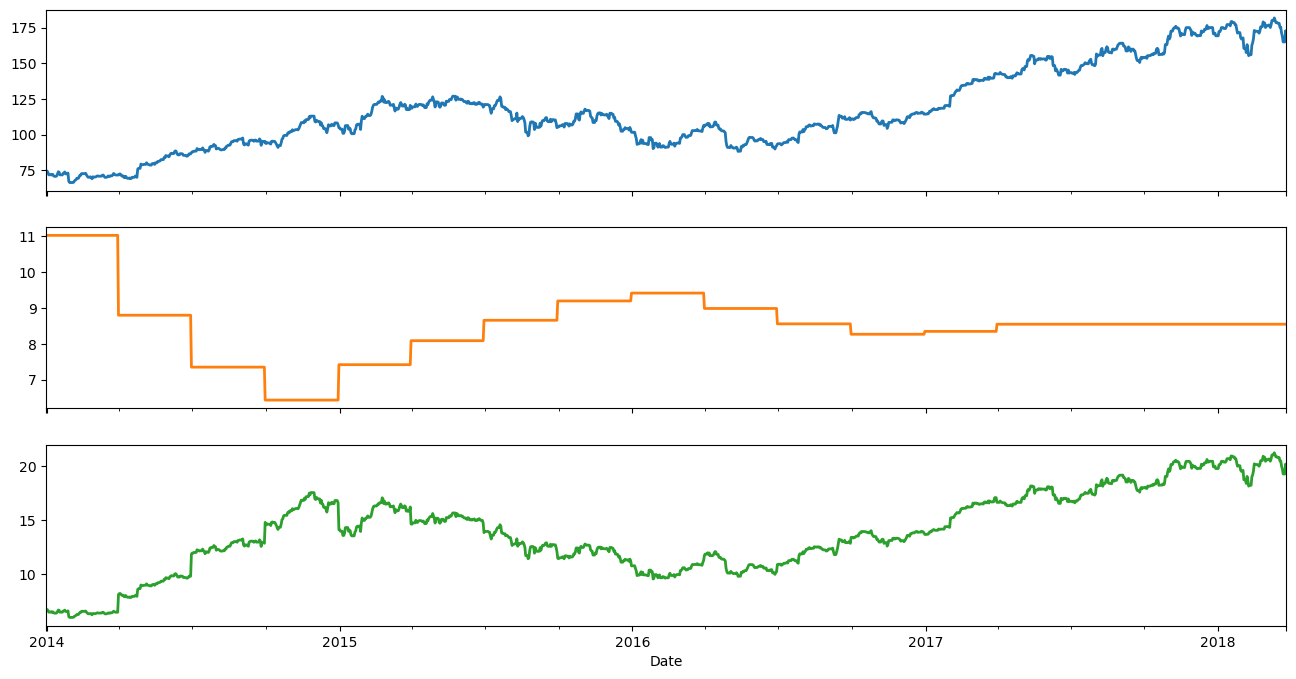

In [87]:
pe = aapl_stock.AdjClose.to_frame('price').join(eps.to_frame('eps')) #Convert the AdjClose into a dataframe with column named price and join with eps 
#join function join the two dataframes by their indices and only take the common indices 
pe = pe.fillna(method = 'ffill').dropna() #fill in NA values by last available value
pe['P/E Ratio'] = pe.price.div(pe.eps)
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2);


In [90]:
#Also check notebooks for comparisons of different data storage methods, Parquet, HDF5 and CSV